### importing libraries

In [1]:
import os 

import librosa as lr
import librosa.display
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
import PIL
from PIL import Image
from IPython.display import display
import pandas as pd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, optimizers, datasets
import sklearn.metrics

The dataset that is used can be found here: [link to dataset](https://urbansounddataset.weebly.com/urbansound8k.html)

First I want to get an overview of the data. Further details on the dataset can also be found in the [write-up](https://github.com/b-ertel/audio-classification-on-a-deaf-machine/audio-classification-on-a-deaf-machine.pdf)

In [2]:
dataframe = pd.read_csv("UrbanSound8K/metadata/UrbanSound8K.csv")
samples = dataframe.sample(10)
samples

,slice_file_name,fsID,start,end,salience,fold,classID,class
8086,78651-5-0-12.wav,78651,6.000000,10.000000,1,6,5,engine_idling
8655,98859-7-0-0.wav,98859,0.338433,3.304703,1,9,7,jackhammer
6734,54173-2-0-5.wav,54173,5.653856,9.653856,2,4,2,children_playing
6507,46656-6-0-0.wav,46656,0.247654,1.666033,1,1,6,gun_shot
8637,98263-9-0-10.wav,98263,5.000000,9.000000,1,6,9,street_music
7674,7389-1-2-2.wav,7389,79.753483,83.753483,2,4,1,car_horn
5132,199261-3-0-2.wav,199261,1.211116,5.211116,1,10,3,dog_bark
3932,177729-0-0-63.wav,177729,31.500000,35.500000,2,7,0,air_conditioner
3475,171305-7-19-0.wav,171305,81.030035,82.575304,1,4,7,jackhammer
6488,44737-5-0-1.wav,44737,0.500000,4.500000,1,7,5,engine_idling


# Visualize an example of the audios with an Amplitudeplot, a Spectrogram and a Melspectrogram
### Details on how these plots differ are described in the [write-up](https://github.com/b-ertel/audio-classification-on-a-deaf-machine/audio-classification-on-a-deaf-machine.pdf)

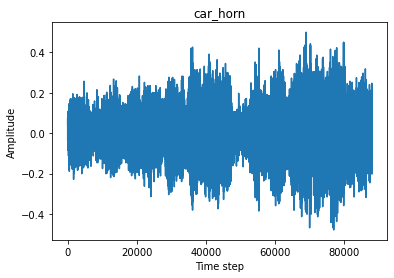

In [3]:
sample1 = samples.iloc[5]
f1 = "UrbanSound8K/audio/fold" + str(sample1['fold']) +"/" + sample1['slice_file_name']
y1, sr1 = librosa.load(f1) #y1 = audio time series; sr1 = sampling rate

#fig, ax = plt.subplots(nrows=1, ncols=1)
plt.plot(y1)
plt.title(str(sample1['class']))
plt.ylabel("Amplitude")
plt.xlabel("Time step")
plt.show()

### Linear Spectrogram

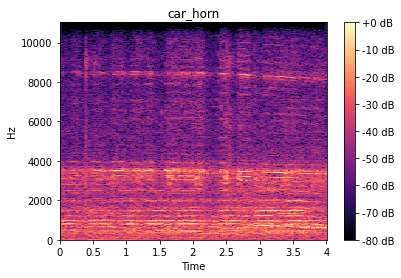

In [5]:
fig, ax = plt.subplots(nrows=1, ncols=1)
D = librosa.amplitude_to_db(np.abs(librosa.stft(y1)), ref=np.max)
img = librosa.display.specshow(D, y_axis='linear', x_axis='time',sr=sr1)
ax.set(title=str(sample1['class']))
fig.colorbar(img, ax=ax, format="%+2.f dB")

### Mel Spectrogram

[Text(0.5, 1.0, 'car_horn')]

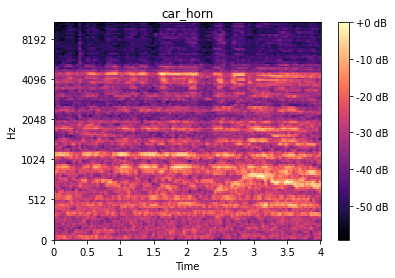

In [7]:
S = librosa.feature.melspectrogram(y=y1, sr=sr1, n_mels=128, fmax=8000)
fig, ax = plt.subplots()
S_dB = librosa.power_to_db(S, ref=np.max)
img = librosa.display.specshow(S_dB, x_axis='time', y_axis='mel', sr=sr1, ax=ax)
fig.colorbar(img, ax=ax, format='%+2.0f dB')
ax.set(title=str(sample1['class']))

#plt.savefig('report/plots/dog_mel.svg')

# Process data
this results in the melspectrograms saved as jpgs. The new dataset can be found [here](https://github.com/b-ertel/audio-classification-on-a-deaf-machine/tree/main/audio_images)

In [ ]:
os.mkdir("audio_images")

#loop over all folds
for i in range(1,11):
    os.mkdir("audio_images/fold"+str(i))
    file_metadata = []
    fold = dataframe[dataframe.fold == i]
    
    #loop over all files in the folds
    for name, class_id in zip(fold.loc[:,'slice_file_name'], fold.loc[:,'classID']):
        filename = "UrbanSound8K/audio/fold" + str(i) +"/" + name
        audio, sr = lr.load(filename)
        mel_spectrogram = lr.feature.melspectrogram(audio, sr)
        db_mel_spectrogram = lr.power_to_db(mel_spectrogram, ref=np.max)
        rescaled = (db_mel_spectrogram + 80) / 80 * 255
        
        #if the image is too small we just repeat the audio sequence to get images of the same size in the end
        while rescaled.shape[1] < 128: 
            rescaled = np.append(rescaled, rescaled, axis = 1)     
        image = Image.fromarray(rescaled.astype(np.uint8))
        image_filename =  name[:-4] + ".jpg"
        image.save("audio_images/fold" + str(i) +"/" + image_filename)
        file_metadata.append([image_filename, class_id])
        
    #metadata in a csv
    file_metadata = pd.DataFrame(file_metadata, columns =["filename", "class_id"])
    file_metadata.to_csv("audio_images/fold" + str(i) +"/file_metadata.csv")